 # Удержание клиентов Фитнес-центра

Cеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. 

Задача — провести анализ и подготовить план действий по удержанию клиентов.
А именно:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

     1) выделить целевые группы клиентов;
     2) предложить меры по снижению оттока; 
     3) определить другие особенности взаимодействия с клиентами.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import datetime as dt

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import stats as st
from datetime import timedelta
import plotly
import re 
import plotly.express as px

import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, silhouette_score
from sklearn.cluster import KMeans

In [2]:
%autosave 30

Autosaving every 30 seconds


In [3]:
# код для отображения таблицы без усечений
pd.options.display.max_columns = 200
pd.options.display.max_colwidth = 250

## Чтение данных и EDA - анализ.

In [4]:
df= pd.read_csv('/datasets/gym_churn.csv')

Данные клиента за предыдущий до проверки факта оттока месяц:
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр; 
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента); 
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента); 
- 'Phone' — наличие контактного телефона; 
- 'Age' — возраст; 
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах). 

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- 'Churn' — факт оттока в текущем месяце.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Можем увидеть, что пропусков нет, 4000 наблюдений, все столбцы по формату соответствуют. Необходимо только переименовать столбцы, что б все было в нижнем регистре

In [6]:
# посмотрим первые 5 строк
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [7]:
#приводим к нижнему регистру названия колон
df.columns = df.columns.str.lower()
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

In [8]:
# посмотрим на аномалии
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Аномалий в данных не обнаружено. 

In [9]:
# проверка на дубликаты
df.duplicated().sum()

0

In [10]:
# посмотрим на средние значения среди тех кто ушел и кто нет.
df.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Влияние признаков на отток и приток
- "gender" (пол) - среднее одинаково, это говорит о том, что этот признак не влияет на отток/приток.(-)
- "near_location" (проживание или работа рядом) - надо отметить высокий показатель и там и там - это значит большая часть клиентов, это те кто проживает и работает рядом. Этот признак слабо влияет на отток (положительно на клиентов).(-)
- "partner" - Также это поле оказавет положительное влияние на клиентов, - среди партнеров оттток меньше.(+)
- "promo_friends" - И это поле оказывает положительное влияние на клиентов, - отток среди "Промщиков" меньше.(+)
- "phone" - много тех кто оставил свои телефоны в анкете, но влияния не имеетт.(-)
- "contract_period" (длительность абонемента) - . Влияние признака на клиентов высокое.(+)
- "group_visits" (груповые тренировки)- среди тех кто ходит на групповые отток меньше(+)
- "age" - средний возраст тех кто не в оттоке выше, но влияние не оказывает(-)
- "avg_additional_charges_total" - кто дольше ходит, тот больше тратит внутри клуба( но влияние здесь нет(-)
- "month_to_end_contract" - есть влияние, кому еще долго ходить, не покидают фитнес-клуб.(+)
- "lifetime" - чем дольше ходит, тем маловероятнее он уйдет.(+)
- "avg_class_frequency_total" - тем чаще ходит, тем менее вероятно он уйдет (+)
- "avg_class_frequency_current_month" - тем чаще ходит, тем менее вероятно он уйдет(+)

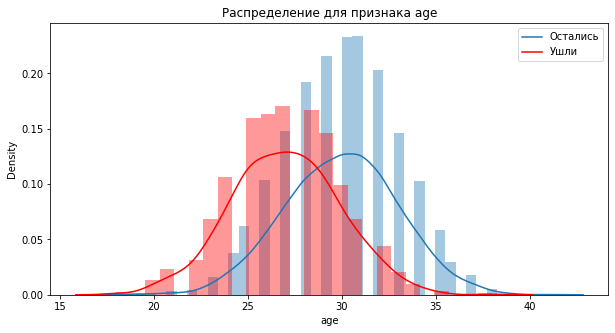

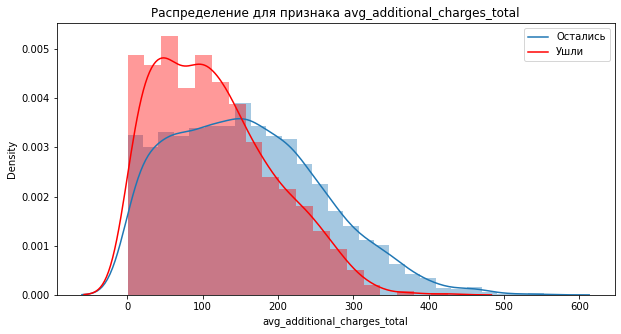

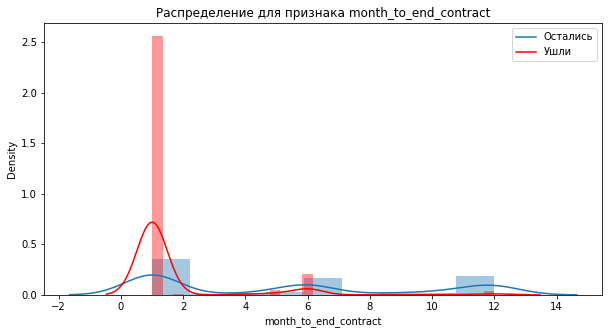

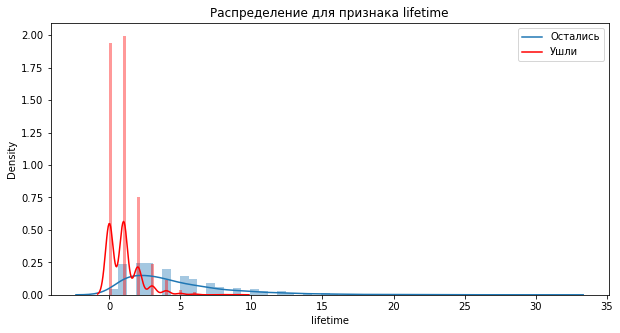

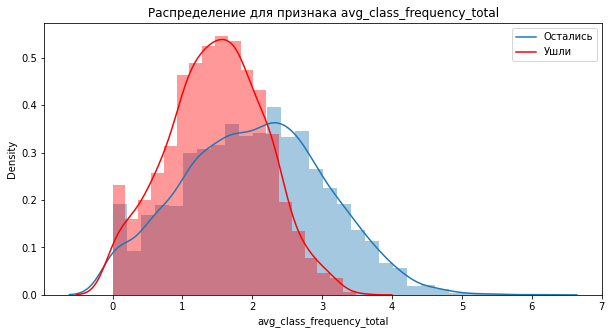

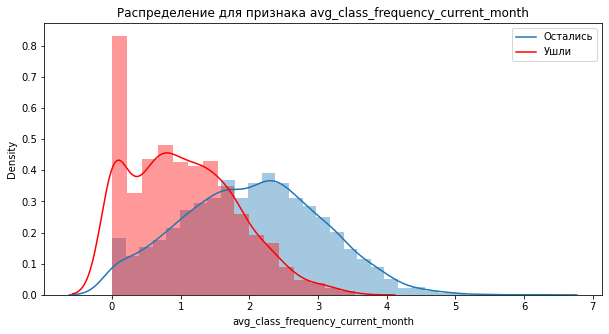

In [11]:
# датасет с небинарными признаками
for_bar = df.drop(columns =(['gender', 'near_location', 
                              'partner','promo_friends', 'phone',
                           'group_visits', 'contract_period', 'churn'])).columns
# функция по построению графиков  влияние признаков на отток
for col in for_bar:
    plt.figure(figsize=(10, 5))
    sns.distplot(df.query('churn == 0')[col])
    sns.distplot(df.query('churn != 0')[col], color = 'r')
    plt.legend(labels = ('Остались', 'Ушли'))
    plt.title('Распределение для признака ' + col)
    plt.show()

- Чем моложе, тем больше вероятности, что клиент уйдет, пик тех кто остается 30 лет.
- Больше всего уходят те, у кого остался месяц до окчания абонемента.
- Больше всего отток происходит в первый месяц, а те, кто ходит уже месяца 4 с меньшей вероятностью уйдет.
- Если человек ходит более 2,5-ух раз в неделю то он скорей всего останется. 
- если последний месяц он не ходит или пришел 1 раз, то считай потеряли клиента.

In [12]:
# датасет с бинарными признаками
binar_bar = df[['gender', 'near_location', 
                              'partner','promo_friends', 'phone',
                              'group_visits', 'contract_period', 'churn']]

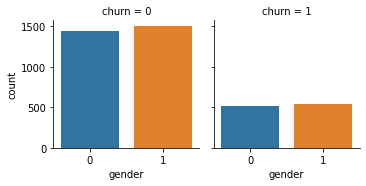

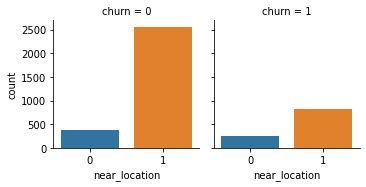

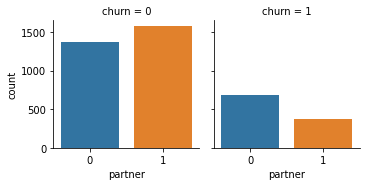

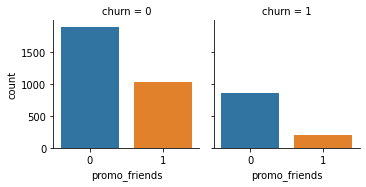

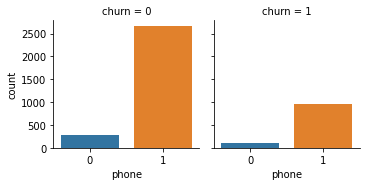

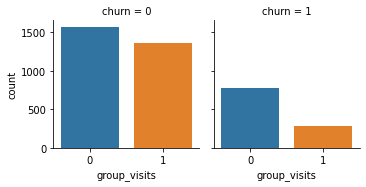

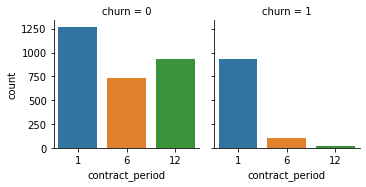

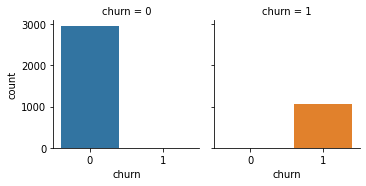

In [13]:
# функция по построению графиков  влияние признаков на отток
for col in binar_bar.columns:
    sns.catplot(col, col="churn", data = binar_bar, kind="count", height=2.5)

Видим, что чаще уходят клиенты которые:

-Покупают абонемент всего на один месяц


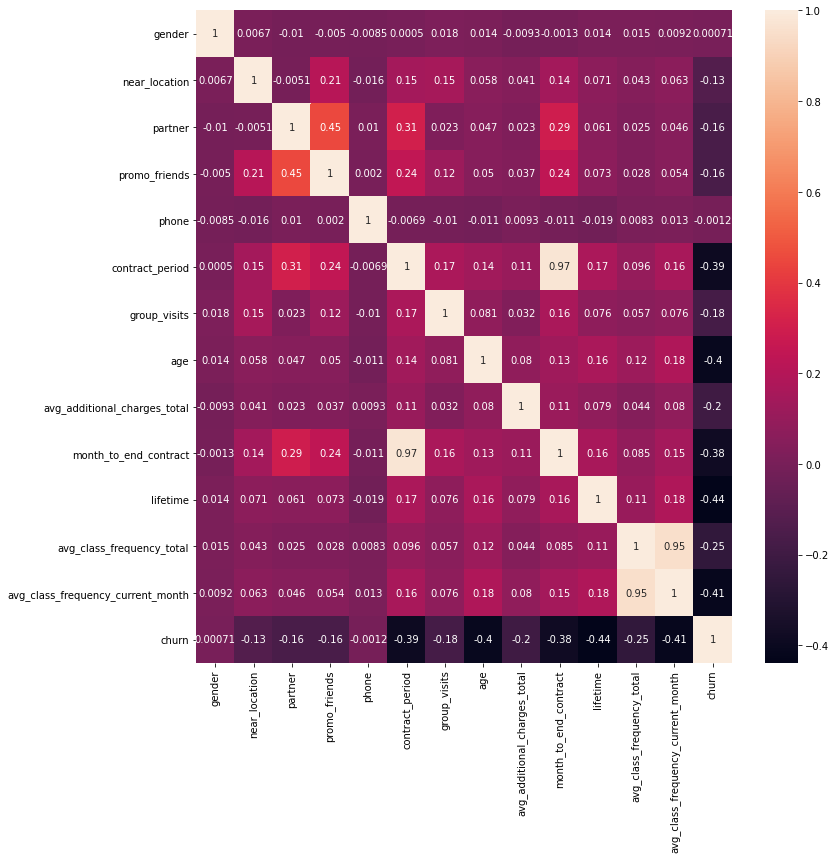

In [14]:
cm = df.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True)
plt.show()

Среди всех признаков на отток больше всего влияет: срок абонемента, возраст, сколько месяцев до окончания абонемента, как долго и часто ходит

### Вывод. 

Во время предобработки мы выявили, что в датасете в 4000 наблюдений не аномалий, пропусков, дубликатов. Во время исследовательского нализа, мы можем предположить, что: 
- Чем моложе, тем больше вероятности, что клиент уйдет, пик тех кто остается 30 лет.
- Больше всего уходят те, у кого остался месяц до окчания абонемента.
- Больше всего отток происходит в первый месяц, а те, кто ходит уже месяца 4 с меньшей вероятностью уйдет.
- Если человек ходит более 2,5-ух раз в неделю то он скорей всего останется.
- Если последний месяц он не ходит или пришел 1 раз, то считай потеряли клиента.
- Если абонемент куплен на месяц, он скорей всего уйдет. 
- Среди всех признаков на отток больше всего влияет: срок абонемента, возраст, сколько месяцев до окончания абонемента, как долго и часто ходит.

## Модель прогнозирования оттока клиентов

In [15]:
# разделим выборку на обучающую и тестовую
X = df.drop('churn', axis = 1)
y = df['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [16]:
#создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train) 

#применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test) 

In [17]:
# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test, name):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Модель прогнозирования -", name)
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
lr_model = LogisticRegression(random_state = 0)        
make_prediction(lr_model, X_train_st, y_train, X_test_st, y_test, 'Логистическая регрессия')    

Модель прогнозирования - Логистическая регрессия
Accuracy: 0.92
Precision: 0.85
Recall: 0.83


In [18]:
forest_model= RandomForestClassifier(n_estimators = 100, random_state=0)
make_prediction(forest_model, X_train_st, y_train, X_test_st, y_test, 'Случайный лес') 

Модель прогнозирования - Случайный лес
Accuracy: 0.92
Precision: 0.84
Recall: 0.81


По всем параметрам "Логистическая регрессия" дает результат немного лучше чем "Случайный лес"
Вывод: Обе модели показали высокте результаты по метрикам, но  "Логистическая регрессия" - немного лучше.

## Кластеризация клиентов

In [19]:
# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(X)

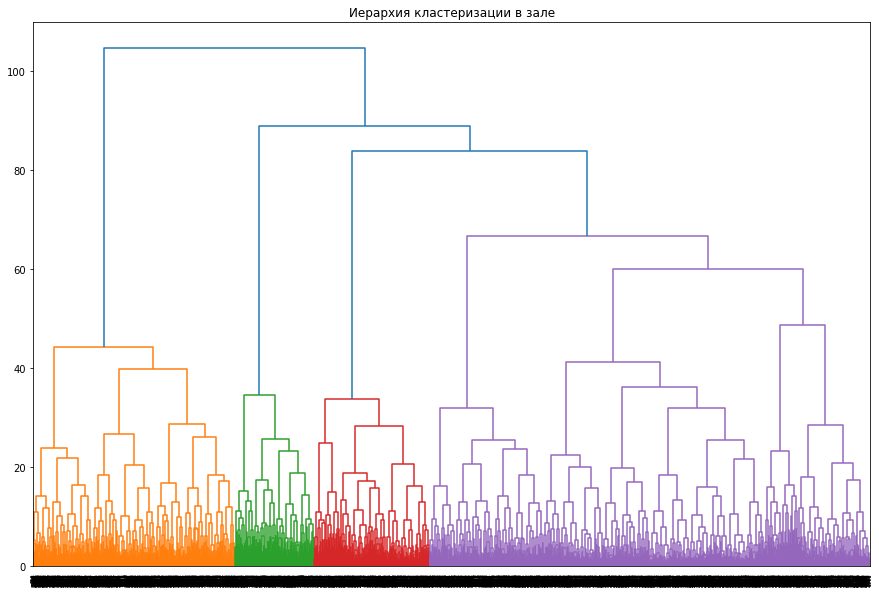

In [20]:
# матрица расстояний функций
linked = linkage(X_sc, method = 'ward')
# отрисовка дендограммы
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархия кластеризации в зале')
plt.show()

Визуально можно разделить на 4-6 классов. Я б поделила на 5, так как фиолетовая группа очень большая и ее можно поделить пополам.

In [21]:
# кластаризация
k = KMeans(n_clusters = 5, random_state=0) # задаём число кластеров, равное 5
labels = k.fit_predict(X_sc) # формируем вектор кластеров

In [22]:
# вставим в табличку каждему пользователю кластер
df['cluster_k'] = labels
df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,cluster_k
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,1
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0,3
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0,3


In [23]:
#  посмотрим среднее  по признакам в разрезе кластеров
df.groupby('cluster_k').mean().T

cluster_k,0,1,2,3,4
gender,0.502970,0.522078,0.495050,0.485737,0.559666
near_location,0.959406,0.862338,0.000000,1.000000,0.976134
partner,0.783168,0.470130,0.463366,0.350238,0.356802
promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
phone,1.000000,0.000000,1.000000,1.000000,0.998807
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
age,29.982178,29.301299,28.477228,28.167987,30.125298
avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


Самый большой отток среди посетителей в 3 и 2 кагорте. Для данных групп характерен возраст 28 лет, самый маленький средний период действия абонемента среди всех кагорт, самое низкое количество посещения груповых занятий, самое низкое количество месяцев до окончания абонемента, низкий лайфтайм, самое низкое среднее количество посещений.  Для второй кагорты характер далекое расположение зала. 
Самый маленький отток в 0 и 4 кагорте . В нулевой выше показатель партнерский и срок абонемента, поэтому в этой кагорте отток меньше.

In [24]:
# разделим датасеты по бинарным и небинарным признакам
non_binary = df.drop(columns =(['gender', 'near_location', 
                              'partner','promo_friends', 'phone',
                              'group_visits', 'churn', 'cluster_k','contract_period', 'month_to_end_contract', 'lifetime']))
binary = df[['gender', 'near_location', 
                              'partner','promo_friends', 'phone',
                              'group_visits', 'contract_period', 'month_to_end_contract', 'lifetime']]

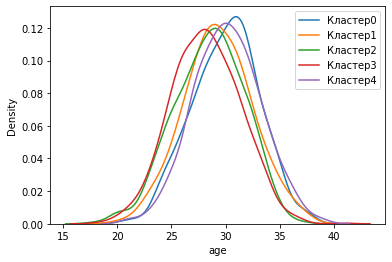

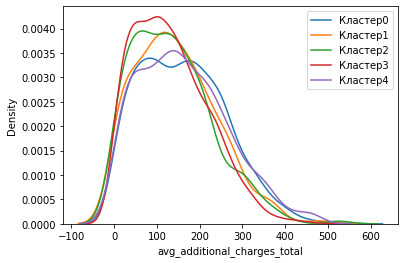

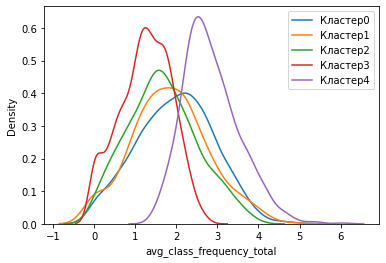

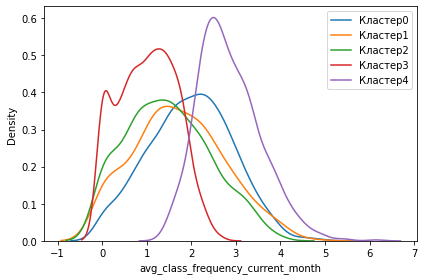

In [25]:
#  функция для построения графиков небинарных признаков
for col in non_binary:
    plt.figure()
    for i in range(0,5):
        sns.distplot(df.query('cluster_k == @i')[col],
                    hist=False,
                    kde_kws={'label':'Кластер'+ str(i)})
    plt.legend()   
plt.tight_layout()

Как видно по графику Age больше всего склонны к оттоку на пике 28 лет(3-й кластер), а надежные кластеры самые возрастные 0-й кластер на пике 32 года, 4-й на пике 30 лет.
Что касается доп.затрат - более надежные кластеры имеют более широкий график, большинство клиентов 3-го кластера тратят меньше,
Самый активный кластер 4-й. Минимальная активность наблюдается у 3-го кластера, в среднем 1 занятие в неделю. Чем клиент активнее в посещяет зал, тем меньше вероятность его оттока

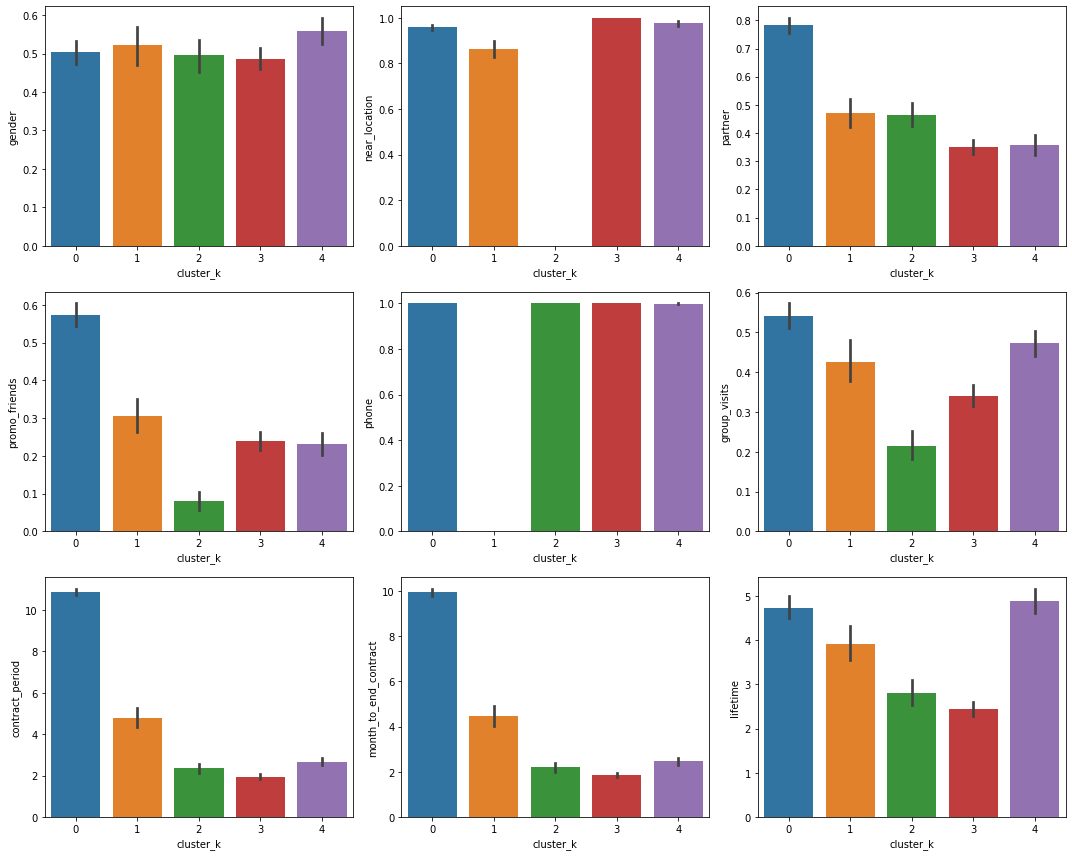

In [26]:
#  функция для построения графиков бинарных признаков
plt.figure(figsize=(15,12))
for i in range(len(binary.columns)):
    plt.subplot(3,3,i+1)
    x = df['cluster_k']
    y = binary.iloc[:,i]
    sns.barplot(x=x, y=y)
plt.tight_layout()
plt.show()

Очень наглядна динамика время с момента первого посещения, чем он ниже тем больше вероятность оттока. Например, 3-ий кластер
Клиенты 2-го кластера живут/работают не рядом с фитнесом
Активнее всего посещают груповые занятия клиенты в 0-ом кластере, что логично, так как у них самый высокий показатель Partner и Promo_frinds, значит у них много знакомых, кто ходит вместе с ними на эти занятия
Чем меньше месяцев до конца абонемента, тем выше вероятность оттока.

###  Вывод

Наиболее оптимальное разделение на кластеры от 4-6, мы взяли 5. 
Мы выявили, что: 
1) Самый большой отток среди посетителей в 3 и 2 кагорте. Для данных групп характерен возраст 28 лет, самый маленький средний период действия абонемента среди всех кагорт, самое низкое количество посещения груповых занятий, самое низкое количество месяцев до окончания абонемента, низкий лайфтайм, самое низкое среднее количество посещений. Для второй кагорты характер далекое расположение зала. Самый маленький отток в 0 и 4 кагорте . В нулевой выше показатель партнерский и срок абонемента, поэтому в этой кагорте отток меньше.

2) Больше всего склонны к оттоку на пике 28 лет(3-й кластер), а надежные кластеры самые возрастные 0-й кластер на пике 32 года, 4-й на пике 30 лет. Что касается доп.затрат - более надежные кластеры имеют более широкий график, большинство клиентов 3-го кластера тратят меньше, Самый активный кластер 4-й. Минимальная активность наблюдается у 3-го кластера, в среднем 1 занятие в неделю. Чем клиент активнее в посещяет зал, тем меньше вероятность его оттока. 

3) Очень наглядна динамика время с момента первого посещения, чем он ниже тем больше вероятность оттока. Например, 3-ий кластер Клиенты 2-го кластера живут/работают не рядом с фитнесом Активнее всего посещают груповые занятия клиенты в 0-ом кластере, что логично, так как у них самый высокий показатель Partner и Promo_frinds, значит у них много знакомых, кто ходит вместе с ними на эти занятия Чем меньше месяцев до конца абонемента, тем выше вероятность оттока.

## Вывод

1) Во время предобработки мы выявили, что в датасете в 4000 наблюдений не аномалий, пропусков, дубликатов. Во время исследовательского нализа, мы можем предположить, что:
- Чем моложе, тем больше вероятности, что клиент уйдет, пик тех кто остается 30 лет.
- Больше всего уходят те, у кого остался месяц до окчания абонемента.
- Больше всего отток происходит в первый месяц, а те, кто ходит уже месяца 4 с меньшей вероятностью уйдет.
- Если человек ходит более 2,5-ух раз в неделю то он скорей всего останется.
- Если последний месяц он не ходит или пришел 1 раз, то считай потеряли клиента.
- Если абонемент куплен на месяц, он скорей всего уйдет.
- Среди всех признаков на отток больше всего влияет: срок абонемента, возраст, сколько месяцев до окончания абонемента, как долго и часто ходит.

2) Наилучшая модель для прогнозирования оттока в данном случае - логистическая регрессия. 

3) Наиболее оптимальное разделение на кластеры от 4-6, мы взяли 5. 
4) Мы выявили, что: 
- Самый большой отток среди посетителей в 3 и 2 кагорте. Для данных групп характерен возраст 28 лет, самый маленький средний период действия абонемента среди всех кагорт, самое низкое количество посещения груповых занятий, самое низкое количество месяцев до окончания абонемента, низкий лайфтайм, самое низкое среднее количество посещений(минимальная активность наблюдается у 3-го кластера, в среднем 1 занятие в неделю). Для второй кагорты характер далекое расположение зала. Самый маленький отток в 0 и 4 кагорте.  Кластер на пике в 32 года. В нулевой выше показатель партнерский и срок абонемента, поэтому в этой кагорте отток меньше.

- Что касается доп.затрат - более надежные кластеры имеют более широкий график, большинство клиентов 3-го кластера тратят меньше.
- Очень наглядна динамика время с момента первого посещения, чем он ниже тем больше вероятность оттока. Например, 3-ий кластер. 
- Активнее всего посещают груповые занятия клиенты в 0-ом кластере, что логично, так как у них самый высокий показатель Partner и Promo_frinds, значит у них много знакомых, кто ходит вместе с ними на эти занятия Чем меньше месяцев до конца абонемента, тем выше вероятность оттока.



**Рекомендации:** 
1) Обратить внимание на новых клиентов, среди них отток самый большой. Возможно стоит им предлагать по акции абонемент на 3 месяца с групповыми занятиями, так как среди таких клиентов отток меньше 
2) Делать акции, если друг купит абонемент на 12 месяцев тебе подарок. 
3) Сделать упор на длительные абонементы и групповые занятия, так как среди таких людей меньше отток.


**Портрет нелояльного клиента:** человек 28 лет, живущий или работающий не рядом с залом, который покупает абонемент на месяц, не ходит на групповые занятия и посещает зал 1 раз в неделю и менее.